# Import packages and modules

In [1]:
import os
from glob import glob
import json
import pandas as pd
import numpy as np
import math, random
import datetime as dt
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks


from module_.info.testbed import activityfiles_new
from module_.info.config import config, feature_name
from module_.readText import create_episodes, time_correction, read_adlmr
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection


In [ ]:
from module_.correlation import correlation

result = correlation("testbed","RuLSIF")

./correlation/testbed/P25-C5


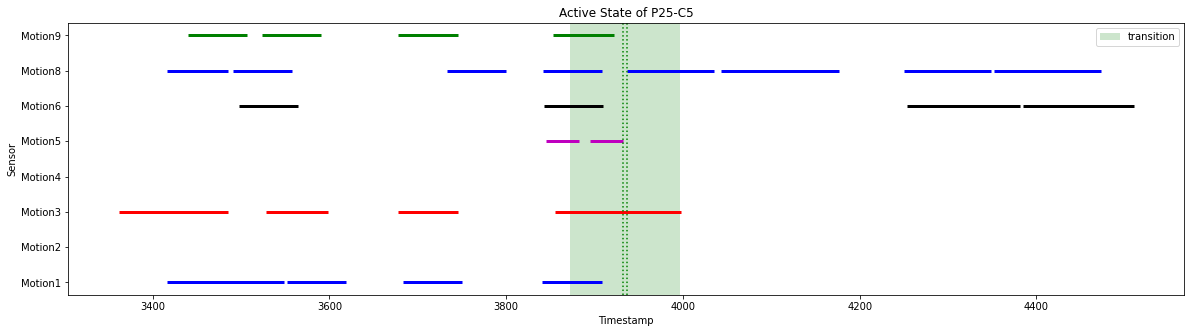

In [24]:
from module_.validation import check_active_state

fig = plt.figure(figsize=(20, 5))
ax = plt.axes()

colorstring = "bgrcmk"

threshold = 60

for d, folder in enumerate(glob("./correlation/testbed/*")):
    
    if d!=1:
        continue
    print(folder)
    pair = folder.split("/")[-1].split(".")[0]
    episode = np.load("{}/episode.npy".format(folder))
    transition = np.load("{}/label.npy".format(folder))[0]

    start_time = float(episode[0,2])
    transition_time_l = float(episode[transition-1,2])-start_time
    transition_time_r = float(episode[transition,2])-start_time

    correlation = np.load("{}/relationships.npy".format(folder))

    active_dict = check_active_state(episode)

    ax.set_title('Active State of {}'.format(pair))
    ax.set_xlabel("Timestamp"); ax.set_ylabel("Sensor")
    ax.set_yticks(range(1, len(active_dict.keys())+1))
    ax.set_yticklabels(active_dict.keys())

    for i, item in enumerate(active_dict.items()):
        k, v = item
        for fragment in v:
            # if fragment[0]>transition_time_l-600 and fragment[1]<transition_time_r+600:
            ax.hlines(y=i+1, xmin=fragment[0], xmax=fragment[1], linewidth=3, color=colorstring[i%len(colorstring)-1])
    
    plt.axvline(
        x=transition_time_l, color="g", linestyle=":"
    )
    plt.axvline(
        x=transition_time_r, color="g", linestyle=":"
    )
    plt.axvspan(max(0, transition_time_l-threshold), min(transition_time_r+threshold, float(episode[-1,2])-float(episode[0,2])), 
        facecolor='g', alpha=0.2, label="transition"
    )

    plt.legend()

    break

In [ ]:
from module_.dataLoader import dataLoader

episodes, transitions, labels = dataLoader("adlmr")

In [ ]:
from module_.prototype import coefficient
# import numpy as np

# test_idx = 6
# episode, transition, label = episodes[test_idx], transitions[test_idx], labels[test_idx]

states = coefficient(episode, lambda_=5)

fig = plt.figure(figsize=(20, 1))
ax = fig.add_subplot(1, 1, 1)

timestamps=[float(timestamp)-float(episode[0,2]) for timestamp in episode[:,2]]
transition_timestamp_r = float(episode[transition,2])-float(episode[0,2])
transition_timestamp_l = float(episode[transition-1,2])-float(episode[0,2])

# print(states)

plt.plot(timestamps, states, '.-', color='b')
# plt.title(label)
# plt.axvline(x=transition_timestamp_l, linestyle=":", color="g")
# plt.axvline(x=transition_timestamp_r, linestyle=":", color="g")
plt.axvspan(0, transition_timestamp_l, facecolor='r', alpha=0.2, 
    #label=label.split("-")[0]
)
plt.axvspan(transition_timestamp_r, float(episode[-1,2])-float(episode[0,2]),
    facecolor='b', alpha=0.2, 
#    label=label.split("-")[1]
)
plt.axvspan(max(0, transition_timestamp_l-threshold), min(transition_timestamp_r+threshold, float(episode[-1,2])-float(episode[0,2])), 
    facecolor='g', alpha=0.2, label="transition"
)
plt.legend()
plt.show()
# print(transition)

## adlmr

In [ ]:
f = open("./dataset/adlmr/annotated", 'rb')
text = f.readlines()
tasks = read_adlmr(text)

events = [e for e in events if e[0][0] in list('MD')]

startindices = [i for i in range(1, len(events)) if events[i][3]!=events[i-1][3]]
startindices = [0]+startindices+[len(events)]

dict_consecutiveActivities = {
    'chunks':[],
    'labels':[],
    'lengths':[],
}

chunksize = 8

CoC=[]
CoLbl=[]
CoLen=[]
for i in range(len(startindices)-1):
    start, end_ = startindices[i:i+2]
    chunk=events[start:end_]

    labelset = list(set(np.array(chunk)[:,3]))
    assert len(labelset)==1
    label = labelset[0]

    if len(CoC)==chunksize:
        dict_consecutiveActivities['chunks'].append(CoC)
        dict_consecutiveActivities['labels'].append(CoLbl)
        dict_consecutiveActivities['lengths'].append(CoLen)
        # CoC = CoLbl = CoLen = []
        CoC, CoLbl, CoLen = [], [], []

    CoC.append(chunk)
    CoLbl.append(label)
    CoLen.append(len(chunk))

"""Test: Second Chunks"""
ti = 3
test_chunk = np.concatenate(dict_consecutiveActivities['chunks'][ti])
test_label = dict_consecutiveActivities['labels'][ti]
test_length = dict_consecutiveActivities['lengths'][ti]

print(test_chunk.shape, test_label, test_length)

transitions = []
start=0
for i in range(len(test_length)-1):
    transitions.append(start+test_length[i])
    start+=test_length[i]